# Data Challenge - Joffrey Ma

This notebook contains the code and report for the Data Challenge of the Mastères IA & BGD at Télécom Paris.\
Due by March 10th, 2023.

# Methodology

The challenge is an image classification task, possibly requiring heavy image preprocessing to get meaningful and relevant features.

Going head down into feature engineering and blind model testing does not bring prospects of obtaining a high score on such a challenge.\
I decided to start by trying out one the latest Hugging Face service : AutoTrain for image classification [https://huggingface.co/blog/autotrain-image-classification]. \
It automatically selects relevant models to try out on a dataset uploaded by the user.\
Initial goals are : 
* to try out the latest machine learning architecture for image classification that hold top positions on benchmarks [https://paperswithcode.com/task/image-classification].
* set a baseline and a foundation for improvements if results are somewhat good compare to the dozen people that already submitted in the past week. 

In its free version, a dataset of under 500 images is allowed. Right what is necessary for the challenge. Data splitting can be left to AutoTrain. As regards models, up to 5 can be compared in the free version. Model selection can also be left to AutoTrain.\
Once data is splitted and models selected, AutoTrain trains them. It decides on its own when to stop training and notice the user of each model training termination.
From the autotrained models, I download the best in term of F1 and evaluate the test dataset and submit on the datachallenge platform.

This experiment fulfilled my goals :
* Swin, ViT, BEiT and ResNet are among selected model, and they show high performances on benchmark of different image classification tasks.
* the associated submission ranked me first, slightly above the previous first.
Plus, it indicates that fine-tuning can really work on very small datasets.  

Now I have my starting point with a Swin vision transformer as Hugging Face delivers the model architecture and weights, the actual image processor and its configuration file.\
However, simply using the autotrained Swin is not satisfactory. At least I should be able to reproduce the results locally, hence proving chance has nothing to do with them. Once the performances are reproduced, I can ponder on how to improve my process if possible.\
Meanwhile if my rank goes below the top 5, I would consider exploring a completely different path. If it remains in the top 5, I stick to the ongoing path. ==> This is what happened !

In this notebook will be presented a simple code to generate data in the format expected by Hugging Face which turns it into a dataset available on its hub [https://huggingface.co/datasets/JoffreyMa/autotrain-data-histopathological_image_classification]. \
Then show how to download the autotrained model [https://huggingface.co/JoffreyMa/autotrain-histopathological_image_classification-3393093038] and use it to make a submission.\
I resume with how to locally obtain similar results, even though Hugging Face AutoTrain does not provide information on its training process.\
Afterwards I present another technic explored and end with leads and prospects of improvements.\
As we go through I explain what is necessary (model architecture, augmentation technics, inner working of Hugging Face Transformers) 

In other words, this notebook summary is the following :
1. Hugging Face Autotrain
    1. Format data
    1. API
    1. Apply
1. Reproduce locally
    1. Configure
    1. Augment data
    1. Balance data
    1. Train
    1. Evaluate
    1. Predict
1. Improve
    1. Mitigate overfitting
    1. Task related
    1. Time

And I will wrap it with a paragraph about some exploration I made and a conclusion of the project.

---

In [1]:
# imports for the notebook
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
from pathlib import Path

from transformers import AutoFeatureExtractor, AutoModelForImageClassification, SwinConfig, SwinForImageClassification, ViTImageProcessor, Trainer, TrainingArguments, DefaultDataCollator

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split, DataLoader, WeightedRandomSampler
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassConfusionMatrix
from torchvision import transforms
from torchvision.datasets import ImageFolder
import gc

import evaluate

# 1. Hugging Face Autotrain

In order to use AutoTrain, one must comply by uploading a folder containing all the images for training and another csv file.\ 

Exemple, content of histopathological_image_classification.csv :\
image_relpath,label\
SOB_B_A-14-22549AB-100-001.png,7\
SOB_B_A-14-22549AB-100-002.png,7\
SOB_B_A-14-22549AB-100-003.png,7\
...

As we can see the csv has 2 columns, one for the image filename and another for the associated label.

## A. Format data

In [2]:
# Paths for this part of the notebook
wd = os.path.join(os.getcwd(), '..')
data = os.path.join(wd, 'data', 'input')
image_train_path = os.path.join(data, 'Train')
image_test_path = os.path.join(data, 'Test')

hf_csv_output_path = os.path.join(wd, 'data', 'output', 'huggingface_autotrain', 'histopathological_image_classification.csv')
hf_submission_path = os.path.join(wd, 'data', 'output', 'submission', 'pred_swin_hf_autotrain.csv')

In [3]:
# Code from the tutorial to process the data

# Get images list from folder using os.listdir
images = os.listdir(path=image_train_path)
images = [image for image in images if Path(image).suffix == '.png']

# Extract info from the filenames
def parse_fn(filename):
    # <BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>-<YEAR>-<SLIDE_ID>-<MAG>-<SEQ>
    parsed = filename[:-4].replace('-', '_').split('_')
    parsed.append(filename)
    return parsed

columns = ['procedure', 'class', 'type', 'magnification', 'slide', 'mag', 'seq', 'filename']

# Store info about files in a pandas DataFrame 
df = pd.DataFrame(list(map(parse_fn, images)), columns=columns)
label_types = df['type'].unique()
# Maps label names to indices
label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
df['type_id'] = df['type'].apply(lambda x: label_maps[x])

# Glimpse at the obtained info
print(df.head(3))

  procedure class type magnification    slide  mag  seq  \
0       SOB     B    A            14  22549AB  100  001   
1       SOB     B    A            14  22549AB  100  002   
2       SOB     B    A            14  22549AB  100  003   

                         filename type_id  
0  SOB_B_A-14-22549AB-100-001.png       7  
1  SOB_B_A-14-22549AB-100-002.png       7  
2  SOB_B_A-14-22549AB-100-003.png       7  


I notice that procedure, magnification, mag always have the same values.\
We have different sequences for each slide.

In [13]:
# Select filename and label indice  
hf = df[['filename', 'type_id']].copy()
hf.columns = ['image_relpath', 'label']
# Save csv, ready for use on Hugging Face 
hf.to_csv(hf_csv_output_path, index=False)
# Glimpse at the csv 
print(hf.head(3))

                    image_relpath label
0  SOB_B_A-14-22549AB-100-001.png     7
1  SOB_B_A-14-22549AB-100-002.png     7
2  SOB_B_A-14-22549AB-100-003.png     7


## B. API

Let's use the best autotrained model.
We must download it along with its extractor.

In [14]:
access_token = 'your_access_token_from_hugging_face' # contact me if necessary

extractor = AutoFeatureExtractor.from_pretrained("JoffreyMa/autotrain-histopathological_image_classification-3393093038", use_auth_token=access_token)
model = AutoModelForImageClassification.from_pretrained("JoffreyMa/autotrain-histopathological_image_classification-3393093038", use_auth_token=access_token)

C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopatho_venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


The extracted model is a Swin transformer for image classification.
More information on that model can be found at [https://github.com/microsoft/Swin-Transformer] and [https://arxiv.org/abs/2103.14030].

## C. Apply

Declare a small dataset class to extract images and their filename.

In [4]:
class HFHistoDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir

    def __len__(self):
        return len(os.listdir(path=self.img_dir))

    def __getitem__(self, idx):
        filename = os.listdir(path=self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path)
        return image, filename

In [5]:
test_data = HFHistoDataset(image_test_path)

Recycle code from datachallenge.enst.fr tutorial to prepare a submission file.

In [6]:
# Test images
images_test = os.listdir(path=image_test_path)

# Number of images
print("Number of images for the test set: ", len(images_test))

columns = ['procedure', 'id', 'filename']

df_test = pd.DataFrame(list(map(parse_fn, images_test)), columns=columns)

Number of images for the test set:  207


Predict on each image of the test set.

In [21]:
types_test = []
for data in test_data:
    inputs = extractor(data[0], return_tensors="pt") # important to extract what the autotrained model needs
    filename = data[1]
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label = logits.argmax(-1).item()
    types_test.append(model.config.id2label[predicted_label])

Write the submission file.

In [22]:
df_test['type_id'] = types_test
df_pred = df_test[['id', 'type_id']]
display(df_pred['type_id'].value_counts())
df_pred.to_csv(hf_submission_path, index=False, header=False)

7    56
2    54
3    29
4    25
5    25
1    17
8     1
Name: type_id, dtype: int64

With this submission, I get 0.778882621975 F1-score and 0.835748792271 Accuracy, ranked first when submitted.

Now I need to reproduce the results locally, at least to prove these results are not obtained by chance. Only then can I improve on this model.

# 2. Reproduce locally

## A. Configure

In [7]:
# device on which computation happens
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# paths for this part of the notebook
config_json = os.path.join(wd, "data", "model", "config", "config.json")
preprocessor_config_json = os.path.join(wd, "data", "model", "config", "preprocessor_config.json")
input_train = os.path.join(wd, "data", "input", "Train")
model_path = os.path.join(wd, "data", "model")
submission_path = os.path.join(wd, 'data', 'output', 'submission', 'pred_swin_local.csv')

Hugging Face gives us key characteristics of the model but not the pre-trained base model with which it fine-tunes. Fortunately, by looking at the architecture of the autotrained swin, I am able to recognize which type of Swin model was used.\

At this stage, two possible pretrained base models exist :
* swin base trained on ImageNet 22K [https://huggingface.co/microsoft/swin-base-patch4-window7-224-in22k]
* swin base trained on ImageNet 1K [https://huggingface.co/microsoft/swin-base-patch4-window7-224]

By looking at the differences in model weights with the autotrained model, we can assume the pre-trained model used is swin base trained on ImageNet 22K.

In [8]:
# Configure the model

# Load pre-trained model
pretrained_model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")

# Open configuration file given by Hugging Face
# contains the architecture of the model
with open(config_json, 'r') as f:
  swin_config_args = json.load(f)
configuration = SwinConfig(**swin_config_args)

# Declare a model with regards to that config
model = SwinForImageClassification(configuration)
# SwinForImageClassification contains a linear (fully connected) layer 
# on top of swin and a softmax to perform classification 

# Swap the blank instanciated swin with the one by Microsoft  
model.swin = pretrained_model.swin

In [9]:
# Configure the image processor

# Load the image processor by Hugging Face
# here the image processor is a brick defined in Hugging Face Transformers
# As they put it :
# An image processor is in charge of preparing input features for vision models
# and post processing their outputs. This includes transformations such as resizing, 
# normalization, and conversion to PyTorch, TensorFlow, Flax and Numpy tensors. 
# It may also include model specific post-processing 
# such as converting logits to segmentation masks.
with open(preprocessor_config_json, 'r') as f:
  vit_prepro_config_args = json.load(f)

# Declare the ViT image processor from the config
extractor = ViTImageProcessor(**vit_prepro_config_args)
# it does normalization, rescaling, and resizing of images

## B. Augment data

In order to avoid overfitting to the training data, one interesting step in our case is to augment available data. By doing so we artificially increase the volume of data and change the data seen by the model as training goes so that it does not find cheaty ways of guessing the label.

A lot of augmentation technics exists, among the ones for images, I chose some that I think would not change the appropriate label and do not generate completely "false" image unrelated to our task of classifying breast tumors histology slides. 

Let's begin by defining our custom Dataset class which will contain code to 

In [10]:
# Utility for the custom Dataset
def parse_type_id(filename):
    parsed = parse_fn(filename)
    label_maps = {'F':'1', 'DC':'2', 'PC':'3', 'PT':'4', 'MC':'5', 'LC':'6', 'A':'7', 'TA':'8'}
    return int(label_maps[parsed[2]])-1

As the model ingest training data, this Dataset subclass augment them.\
Some augmentations require a bit of explanation.\
* ColorJitter randomly modifies here the brightness, saturation and hue. The idea is that images with acquired with microscope h&e staining protocol can have a lot of variance for instance the colors of nuclei (~ blue), cytoplasm (~ pink), erythrocytes (~ red).
* slides do not have any orientation, our model should analyse images flipped or rotated anyhow
* rotations produce 0-valued pixels in the image, which could be seen as missing or masked data with which the model should deal. I even add random erasing so that missing data can happen anywhere. 
* zooms, in and out. All input images are taken with the same magnification x40, it might be different on the test set. It could improve the models understanding of ratios of what it sees on the images.
Others could be included, we will discuss that matter in the 'Improve' section.

In [11]:
# subclass of torch Dataset 
class HistoDataset(Dataset):
    def __init__(self, img_dir, train=False, predict=False):
        self.img_dir = img_dir
        self.train = train
        self.predict = predict

    def __len__(self):
        return len(os.listdir(path=self.img_dir))

    def __getitem__(self, idx):
        filename = os.listdir(path=self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path)
        if self.train:
            composed = transforms.Compose([transforms.ColorJitter(brightness=.1, contrast=0, saturation=.1, hue=.1),
                                transforms.RandomHorizontalFlip(0.3), 
                                transforms.RandomVerticalFlip(0.3),
                                transforms.TrivialAugmentWide(),
                                transforms.RandomApply(transforms=[transforms.RandomResizedCrop(size=(460, 700))], p=0.5),
                                transforms.RandomAffine(degrees=(30), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                                transforms.RandomErasing(0.5),
                                ])
            image = composed(image)
        if self.predict:
            label='Unknown'
        else:
            label = parse_type_id(filename)
        image_features = extractor(image, return_tensors="pt").pixel_values.squeeze(0)
        return {'pixel_values':image_features, 'label':label, 'filename':filename}

Data are splitted between a training and a validation set with a ratios of 0.78, 0.22 respectively (330 and 92 images). A standard choice, close to what Hugging Face did with our data previously before AutoTrain.\
Both sets should be big enough to learn and evaluate our model. \
Other data splitting methods look less relevant at first glance. \
For instance, cross-validation would be too time consuming since training time is long in this notebook. More important, even if computation goes fast, I need enough data so that the remaining validation fold is representative of the training data. I might not be able to get enough folds.

In [12]:
# Declare a train set
# with seed=42 to reproduce it
histoDataset_train = HistoDataset(input_train, train=True)
train_dataset, _ = random_split(histoDataset_train, [0.78, 0.22], generator=torch.Generator().manual_seed(42))

# Declare a validation set
# Thanks to the seed I can reproduce the split 
# and get a sub HistoDataset with train set to False
# so that no augmentation happens on the validation set
histoDataset_eval = HistoDataset(input_train, train=False)
_, eval_dataset = random_split(histoDataset_eval, [0.78, 0.22], generator=torch.Generator().manual_seed(42))

len(train_dataset), len(eval_dataset)

(330, 92)

## C. Balance data

As seen in the tutorial, classes are imbalanced. This is an issue as the test data of the challenge might have a different distribution.\
Without knowing the distribution of the test data, I can try to equalize the amount of data seen in each class by the model.\
My hope is then to get more robust results and not over-classify as "PC" or under-classify as "TA".

One way of rebalancing is to modify how to sample data to feed to the model.\
With Hugging Face Transformers, it can be done with a custom train data loader.

As far as AutoTrain is concerned their seems to be no way of telling if such balancing procedure was performed.

In [13]:
class HistoTrainer(Trainer):
    def compute_label_counts(self):
        """Compute the number of samples per class in the training dataset."""
        label_counts = {}
        for elt in self.train_dataset:
            label = elt['label']
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
        label_counts = dict(sorted(label_counts.items(), key=lambda x: x[0]))
        return label_counts
    
    def get_train_dataloader(self):
        train_dataset = self.train_dataset
        data_collator = self.data_collator
        if isinstance(train_dataset, Dataset):
            train_dataset = self._remove_unused_columns(train_dataset, description="training")
        else:
            data_collator = self._get_collator_with_removed_columns(data_collator, description="training")
            
        label_counts = self.compute_label_counts()
        max_samples = max(label_counts.values())
        classes_weights = {k: max_samples/v for k, v in label_counts.items()}
        sample_weights = torch.DoubleTensor([classes_weights[elt['label']] for elt in train_dataset]).cuda()
        
        # In case we want to get the same probability for each image to get drawn
        # sample_weights = torch.DoubleTensor([1 for elt in train_dataset]).cuda()
        
        # Calculate class weights based on the frequency of each class in the training dataset
        # Create a weighted sampler that oversamples the minority classes during training
        train_sampler = WeightedRandomSampler(sample_weights, len(self.train_dataset))

        train_dataloader = DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=train_sampler,
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )
        return train_dataloader
    
    # If weights for classes are needed
    # Or custom loss 
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        # if after the training I get errors on specific classes 
        # I can adjust their importance in the loss
        loss_fct = CrossEntropyLoss(weight=torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]).cuda()) # 0.1 everywhere means it is not necessary to weigh here
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

It happens that without such balancing you can already get good results.

We are going to see that with the training.

## D. Train

The Transformers library contains useful objects to fine-tune pre-trained models.\
Especially Trainer and its TrainingArguments.\
They avoid writing explicitly the training loop like in regular pytorch, while taking care of the optimizer with the latest ones implemented.

The main arguments to toy with are the number of training epochs, the learning rate, the number of warmup steps for the scheduler, the weight decay.\
I choose the number of training epochs so to try to reach overfitting the data (from experience here it varies from 32 to 256 epochs). I use a strategy of regularly saving intermediate models. Hopefully some perform well without overfitting. Beware it is greedy in memory and needs 10s of gigabytes. Checkpoints are stored in the declared output directory.\
Learning rate is set low at 5e-5 for fine-tuning, not to loose the profits of microsoft swin backbone.\
Batch sizes are the maximum values that operate on my setup. They are quite low too, which certainly has a regularizing effect.

Note that I tried freezing the swin and training only the classifier, then unfreezing progressively layers as suggested in keras documentation for instance [https://keras.io/guides/transfer_learning/]. That did not appear to work better in my case.

In [14]:
training_args = TrainingArguments(
    output_dir='../data/output/swin',          # output directory
    num_train_epochs=256,              # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    #warmup_ratio=0.01,
    warmup_steps=50,                # number of warmup steps for learning rate scheduler
    logging_dir='../data/log',            # directory for storing logs
    logging_strategy="steps",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    remove_unused_columns = False,
    weight_decay=0.01,
    learning_rate=5e-5,
    #gradient_accumulation_steps=4,
    #ignore_data_skip=True,
    #resume_from_checkpoint=True,
)

trainer = Trainer( #or HistoTrainer to balance the data 
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=eval_dataset,            # evaluation dataset
    #data_collator=DefaultDataCollator(return_tensors="pt"),
    #tokenizer=extractor,
)

In [15]:
# to avoid some rare memory errors during training
# empty the unused cache memory of the device
torch.cuda.empty_cache()
gc.collect()

48

In [16]:
# example in case training is stopped and need to resume from a checkpoint
# checkpoint_path = os.path.join(wd, "data", 'output/swin/checkpoint-8400')
# trainer.train(checkpoint_path)
trainer.train()

Loading model from C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\histopathological\..\data\output/swin/checkpoint-8400.
C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopatho_venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 330
  Num Epochs = 256
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10752
  Number of trainable parameters = 86751424
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 200
  Continuing training from global step 8400
  Will skip the first 200 epochs then the f

0it [00:00, ?it/s]

Step,Training Loss,Validation Loss
8450,0.132000,0.020227
8500,0.070400,0.154176
8550,0.160700,0.165618
8600,0.135000,0.204840
8650,0.051400,0.138839
8700,0.042000,0.036614
8750,0.127600,0.056470
8800,0.111100,0.066166
8850,0.035800,0.123400
8900,0.061900,0.090580


***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
Saving model checkpoint to ../data/output/swin\checkpoint-8500
Configuration saved in ../data/output/swin\checkpoint-8500\config.json
Model weights saved in ../data/output/swin\checkpoint-8500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
Saving model checkpoint to ../data/output/swin\checkpoint-8600
Configuration saved in ../data/output/swin\checkpoint-8600\config.json
Model weights saved in ../data/output/swin\checkpoint-8600\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
***** Running Evaluation *****
  Num examples = 92
  Batch size = 16
Saving model checkpoint to ../data/output/swin\checkpoint-8700
Configuration saved in ../data/output/swin\checkpoint-8700\config.json
Model weights saved in ../data

TrainOutput(global_step=10752, training_loss=0.015949651122181878, metrics={'train_runtime': 5356.994, 'train_samples_per_second': 15.77, 'train_steps_per_second': 2.007, 'total_flos': 6.619101782196879e+18, 'train_loss': 0.015949651122181878, 'epoch': 256.0})

In [17]:
# Save the last model obtained for good measure, it might be good
trainer.save_model(model_path)

Saving model checkpoint to C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\histopathological\..\data\model
Configuration saved in C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\histopathological\..\data\model\config.json
Model weights saved in C:\Users\Shadow\Documents\Projets\MastereIA\DataChallenge\histopathological\histopathological\..\data\model\pytorch_model.bin


To get a better view on the training, a classical chart of the loss evolution for train and eval set.

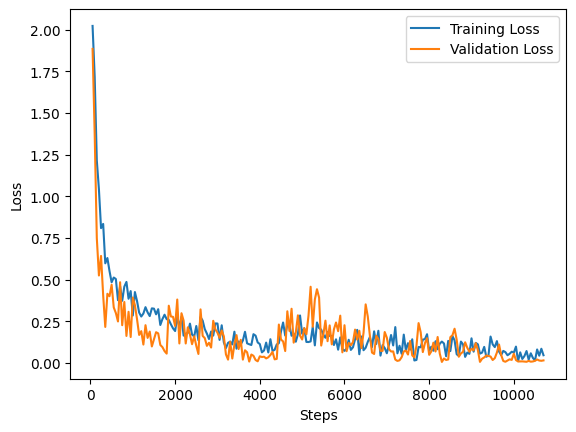

In [33]:
# Loss evaluations history is contained in each checkpoint
# The entire history is in the last checkpoint
history_path = os.path.join(wd, "data", "output/swin/checkpoint-10700/trainer_state.json")
with open(history_path) as f:
    data = json.load(f)

train_losses = []
eval_losses = []
steps = []

for item in data['log_history']:
    if 'loss' in item:
        train_losses.append(item['loss'])
        steps.append(item['step'])
    if 'eval_loss' in item:
        eval_losses.append(item['eval_loss'])

plt.plot(steps, train_losses, label='Training Loss')
plt.plot(steps, eval_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## E. Evaluate

To make sure results are satisfactory the loss value is not enough. Other metrics are necessary, like the F1-Score (weighted average) chosen for the challenge.\
These metrics although computable at train are computed after training in this notebook,
so it does not overload training. for Plus there is a strong correlation between loss and the F1-Score, so I can make an approximation by supervising the loss.

In [18]:
# in case the evaluated model is a checkpoint
# checkpoint_path = torch.load(os.path.join(wd, "data", 'output/swin/checkpoint-10700/pytorch_model.bin'))
# model.load_state_dict(checkpoint_path)

# Set the model to evaluation mode
model.eval()

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [19]:
def tensor_labels_preds(dataset):
    '''Returns labels and predictions as tensors'''
    labels = []
    preds = []
    with torch.no_grad():
        for data in dataset:
            labels.append(data['label'])
            x = data['pixel_values'][None, :].to(device) # important if inputs and weights are not on the same processing unit
            preds.append(model(x).logits.argmax(-1).item())
    return torch.tensor(labels), torch.tensor(preds)

def confusion_matrix(labels, preds):
    metric = MulticlassConfusionMatrix(num_classes=8)
    return metric(labels, preds)

In [20]:
train_labels, train_preds = tensor_labels_preds(train_dataset)

In [21]:
eval_labels, eval_preds = tensor_labels_preds(eval_dataset)

In [22]:
confusion_matrix(train_labels, train_preds) # train_dataset is not deterministic due to augmentations

tensor([[62,  0,  0,  1,  0,  0,  0,  0],
        [ 0, 35,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 64,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 42,  0,  0,  0,  0],
        [ 0,  0,  1,  0, 45,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 13,  0,  0],
        [ 0,  0,  1,  0,  0,  0, 55,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

Apparently training went pretty good, how about the validation set ?

In [23]:
confusion_matrix(eval_labels, eval_preds)

tensor([[10,  0,  0,  1,  0,  0,  0,  0],
        [ 0, 11,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 26,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 13,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 13,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  3,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 10,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  5]])

Good too ! With such small data and convincing result it is hard to say on what the model could possibly perform badly.\
Notice that with this setup predicting on the eval set is actually easier than on the train set.

Before going onto predicting on the test data, let's check if we get metrics of the same order of magnitude as AutoTrain.\
These are displayed on the model page on Hugging Face, but I remind them here :

    Loss: 0.179
    Accuracy: 0.966
    Macro F1: 0.959
    Micro F1: 0.966
    Weighted F1: 0.966
    Macro Precision: 0.969
    Micro Precision: 0.966
    Weighted Precision: 0.969
    Macro Recall: 0.954
    Micro Recall: 0.966
    Weighted Recall: 0.966
    
Getting all these metrics is easy with Transformers.

In [24]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")


def compute_metrics (labels, preds):
    results = {}
    results.update(accuracy_metric.compute(predictions=preds, references = labels))
    results.update({'f1_macro':f1_metric.compute(predictions=preds, references = labels, average="macro")['f1']})
    results.update({'f1_micro':f1_metric.compute(predictions=preds, references = labels, average="micro")['f1']})
    results.update({'f1_weighted':f1_metric.compute(predictions=preds, references = labels, average="weighted")['f1']})
    results.update({'precision_macro':precision_metric.compute(predictions=preds, references = labels, average="macro")['precision']})
    results.update({'precision_micro':precision_metric.compute(predictions=preds, references = labels, average="micro")['precision']})
    results.update({'precision_weighted':precision_metric.compute(predictions=preds, references = labels, average="weighted")['precision']})
    results.update({'recall_macro':recall_metric.compute(predictions=preds, references = labels, average="macro")['recall']})
    results.update({'recall_micro':recall_metric.compute(predictions=preds, references = labels, average="micro")['recall']})
    results.update({'recall_weighted':recall_metric.compute(predictions=preds, references = labels, average="weighted")['recall']})
    return results

In [25]:
compute_metrics(train_labels, train_preds)

{'accuracy': 0.990909090909091,
 'f1_macro': 0.9931065823418764,
 'f1_micro': 0.990909090909091,
 'f1_weighted': 0.9908870667929491,
 'precision_macro': 0.9930663388543823,
 'precision_micro': 0.990909090909091,
 'precision_weighted': 0.9910771796641361,
 'recall_macro': 0.9933051444679352,
 'recall_micro': 0.990909090909091,
 'recall_weighted': 0.990909090909091}

In [26]:
compute_metrics(eval_labels, eval_preds)

{'accuracy': 0.9891304347826086,
 'f1_macro': 0.9894179894179894,
 'f1_micro': 0.9891304347826086,
 'f1_weighted': 0.9891879457096849,
 'precision_macro': 0.9886363636363636,
 'precision_micro': 0.9891304347826086,
 'precision_weighted': 0.9901185770750989,
 'recall_macro': 0.9910714285714286,
 'recall_micro': 0.9891304347826086,
 'recall_weighted': 0.9891304347826086}

Well it's look close enough to me.\
It is time to make a submission.

## F. Predict

In [27]:
test_data = HistoDataset(image_test_path, predict=True, train=False)
types_test = []
for data in test_data:
    #inputs = extractor(data['pixel_values'], return_tensors="pt") # ==> wasted days because I forgot to remove that
    with torch.no_grad():
        x = data['pixel_values'][None, :].to(device)
        predicted_label = model(x).logits.argmax(-1).item()
        types_test.append(model.config.id2label[predicted_label])

Reminder of autotrained model results :\
```
7    56
2    54
3    29
4    25
5    25
1    17
8     1
```
If the results are too far from this it is not even worth submitting

In [28]:
df_test['type_id'] = types_test
df_pred = df_test[['id', 'type_id']]
display(df_pred['type_id'].value_counts())
df_pred.to_csv(submission_path, index=False, header=False)

7    57
2    47
3    36
4    24
1    21
5    21
8     1
Name: type_id, dtype: int64

Not bad ! It's close enough to me to what I get with AutoTrain.\
At submission I obtain a F1-score of 0.815458990715 (when the challenge closed I was at ~ 0.78 at 4th place). 

# 3. Improve

## A. Mitigate overfitting

Without any data augmentation, this swin classifier overfits quickly on its training data.\
Adding some augmentations allowed me to push far back this overfitting.

It also gets me close to AutoTrain results, but still under.\
Nonetheless, the loss gets very low for both train and validation data. It suggests I might have extracted all the information I could on the train data. \
More relevant transformations could dwindle overfitting even more while increasing the volume of data and information at the same time.

Looking at other codes for fine-tuning, I encountered multimodal mixup for fine-tuning [https://github.com/bwconrad/vit-finetune/blob/main/src/mixup.py] which I'm curious about. It supposedly improve performances while being generic.

## B. Task related

A criticism to this model driven approach is the lack of understanding of what it is I classify.\
Understanding the data might bring better results but even if not easy to incorporate that knowledge into the Swin transformer. A combination of the Swin transformer others models trained on hand defined features could improve results. Such model combinations were previously popular on challenge platforms such as Kaggle.

## C. Time

Time being important for the data challenge it is better to be able to iterate quickly.\
Training in this notebook is slow, it takes around 30 minutes to get a idea of how training goes.\
Solutions exists to accelerate training, but could not but be tested on my Shadow machine.\
Solutions include python libraries such as Hugging Face Accelerate, Microsoft DeepSpeed, Amazon Sagemaker, or at least get out of the notebook format to execute on Télécom cluster.

---

For quite some time I could not reproduce results from Hugging Face which was problematic. My submissions got me bad result on the datachallenge with F1 under 0.40. It is only after trying another method involving another model that I realized my mistake : the one contained in the cell of section F when predicting for the submission. 
```
inputs = extractor(data['pixel_values'], return_tensors="pt")
```
This line of code was coming from the early stage of predicting with the autotrained model. Unfortunately it means that I was the image processor on an already processed image. That issue effectively prevented me to go beyond the fine-tuning of swin with the time I could dedicate to the challenge. 

About the other method I tried, I used Swin to produce an embedding of images with 1028 features and feed it to an XGboost algorithm. A naive version of it gave me poor results while simultanously unlocking my issue mentionned above.

Too bad I did not spend time improving over Hugging Face model but the challenge was the opportunity to try state-of-the-art models and benchmark fine-tuning against a variety of methods submitted by other students. It definetly shows impressive performances in little time and computing power if you know how to do it.